# Tic-tac-toe game

In this notebook we'll use the very simple but well known game tic-tac-toe, also called noughts and crosses or "križci in krožci ali tri v vrsto" in Slovene, to demonstrate the concepts of two-player or adversarial search. We will take a look at the minimax algorithm, alpha-beta pruning, and also Monte-Carlo sampling and how to use it to play the game.

The game is implemented as the class TicTacToe which needs to implement the methods __ init __ for initialisation (start) of the game, Move and UndoMove to make/undo a move, GenerateMoves to find possible moves in a given position, and isTerminal to check whether the game is finished (and to set the result).

The game board (position) is represented as a simple array of nine numbers, 0 means empty, 1 a cross, and -1 a nought. The crosses always move first. The game ends when one side has three-in-a-row or there are no move moves possible (the board is full).

In [1]:
# imports and constants
from random import random, randint, seed
from copy import deepcopy

inf = 1000000

In [53]:
class TicTacToe:
    def __init__(self, smartMoveGeneration = False):
        # empty 3x3 board at the start
        # for ease of programming: it's always crosses ("x") starting, noughts ("o") going second
        # crosses will be represented as plus ones (1), noughts as minus ones (-1)
        self.Pos = [0] * 9
        self.ptm = 1  # crosses to move (ptm stands for player-to-move)
        self.won = 9  # indicating still ongoing game (otherwise -1/+1 for won game, 0 for draw)
        self.smartMoveGeneration = smartMoveGeneration
        
    def ID(self):
        # ID is simply the same as Pos (an array of nine numbers)
        return self.Pos
    
    def PrintPosition(self):
        piece = [' O ', '   ', ' X ']
        print(piece[self.Pos[0]+1] + '|' + piece[self.Pos[1]+1] + '|' + piece[self.Pos[2]+1])
        print('---+---+---')
        print(piece[self.Pos[3]+1] + '|' + piece[self.Pos[4]+1] + '|' + piece[self.Pos[5]+1])
        print('---+---+---')
        print(piece[self.Pos[6]+1] + '|' + piece[self.Pos[7]+1] + '|' + piece[self.Pos[8]+1])
        
    def Move(self, move):
        self.Pos[move] = self.ptm  # it's handy that ptm (1 or -1) also denotes "X" or "O"
        self.ptm *= -1  # it's now other player's turn
        
    def UndoMove(self, move):
        # simply erase the piece and reverse ptm
        self.Pos[move] = 0
        self.ptm *= -1
        self.won = 9
    
    def GenerateMoves(self):
        # the piece of the ptm can simply be put into any empty place (designated by 0)
        # and since ptm is kept as part of the state, we simply list all the empty places
        
        # if smart move generation is selected, first centre, then corners, then the rest
        # are generated 
        if self.smartMoveGeneration:
            return [x for x in [4,0,2,6,8,1,3,5,7] if self.Pos[x] == 0]
        
        # no smart move generation (default setting)
        return [ix for ix, x in enumerate(self.Pos) if x == 0]

    def isTerminal(self):
        # the position is terminal if one of the players won or all squares are occupied
        for ix in [0,3,6]:  # rows
            s = sum(self.Pos[ix:ix+3])
            if abs(s) == 3:
                self.won = s // 3
                return True
        for ix in [0,1,2]:  # columns
            s = self.Pos[ix] + self.Pos[ix+3] + self.Pos[ix+6]
            if abs(s) == 3:
                self.won = s // 3
                return True
        # first diagonal
        s = self.Pos[0] + self.Pos[4] + self.Pos[8]
        if abs(s) == 3:
            self.won = s // 3
            return True
        # second diagonal
        s = self.Pos[2] + self.Pos[4] + self.Pos[6]
        if abs(s) == 3:
            self.won = s // 3
            return True
        # if we reached this point the game was not won by any player
        # but we still need to check if it's drawn (no more moves possible)
        if not self.GenerateMoves():
            self.won = 0
            return True
        return False

### Getting a feel for it: making some moves and playing a random game

In [77]:
ttt = TicTacToe()  # creating a game object, starting with an empty board of course
ttt.Move(2)        # playing a cross in top-right corner
ttt.Move(4)        # playing a nought into the center
ttt.Move(5)        # playing a cross middle-right

In [78]:
ttt.PrintPosition()  # position after the moves made above

   |   | X 
---+---+---
   | O | X 
---+---+---
   |   |   


In [79]:
ttt.isTerminal()

False

In [80]:
# the position is not terminal
# and the following moves can be played next (0 is top-left, 8 is bottom-right)
ttt.GenerateMoves()

[0, 1, 3, 6, 7, 8]

In [10]:
# play a random game
ttt = TicTacToe()
while not ttt.isTerminal():
    moves = ttt.GenerateMoves()
    ttt.Move(moves[randint(0,len(moves)-1)])  # make a random move
    ttt.PrintPosition()
    print()
print(['Noughts won!','Draw.','Crosses won!'][ttt.won+1])

   |   |   
---+---+---
 X |   |   
---+---+---
   |   |   

 O |   |   
---+---+---
 X |   |   
---+---+---
   |   |   

 O | X |   
---+---+---
 X |   |   
---+---+---
   |   |   

 O | X | O 
---+---+---
 X |   |   
---+---+---
   |   |   

 O | X | O 
---+---+---
 X |   |   
---+---+---
   | X |   

 O | X | O 
---+---+---
 X | O |   
---+---+---
   | X |   

 O | X | O 
---+---+---
 X | O | X 
---+---+---
   | X |   

 O | X | O 
---+---+---
 X | O | X 
---+---+---
 O | X |   

Noughts won!


### Adversarial search algorithms that enable computers to play the game

In this subsection we define several two-player search algorithms that are used to actually play the game. That means to play the game smartly and not just making random moves as in the game above.

First we implement the basic minimax algorithm, and then its minimax with alpha-beta pruning which is to this day still used to play games for which good heuristics have been designed.

Alternatively, we also implement a simple Monte-Carlo algorithm to demonstrate the power of sampling. This algorithm can operate without a heuristic function. Its more advanced version is Monte-Carlo Tree Search (MCTS). One can look at MCTS as Monte-Carlo with (much) smarter sampling (use of available time).

#### Heuristic functions

Here we define heuristic functions used to evaluate the position. They are deliberately defined outside the TicTacToe class as we wish to compare different heuristics when playing.

In [25]:
# the most basic heuristic function
# for terminal positions it returns the true value: 
#   +inf if crosses win, -inf if noughts win, 0 for draws
# for nonterminal positions it returns 0 (no guidance)
# still this heuristic is not *completely* stupid: it generally results in random play,
#   but avoids lost positions it sees (depending on search depth)
#   and grabs the winning positions it sees!

def basicHF(state):
    # for terminal nodes returns +/- infinity if won or zero for drawn game
    # for nonterminal nodes returns zero
    if state.isTerminal(): 
        return state.won * inf
    else:
        return 0

In [26]:
# a more advanced heuristic function
# as above, for terminal positions it returns the true value
# but for nonterminal positions it returns "the quality of position/pieces" calculated as:
# for each piece it evaluates it as 4 if it's in the centre of the board,
# as 3 if it's in the corner, and as 2 otherwise
# noughts are multiplied by -1
# in this way the heuristic is the weighted difference between positions of crosses and noughts

def positionalHF(state):
    # for terminal nodes returns +/- infinity if won or zero for drawn game
    # for nonterminal nodes returns a heuristic evaluation as described above
    squareValues = [3,2,3,2,4,2,3,2,3]
    if state.isTerminal(): 
        return state.won * inf
    else:
        return sum([x*squareValues[ix] for ix, x in enumerate(state.Pos)])

In [41]:
ttt.PrintPosition()

   |   | X 
---+---+---
   | O | X 
---+---+---
   |   |   


In [42]:
basicHF(ttt)

0

In [43]:
positionalHF(ttt)

1

The basic heuristic function for the position above gives 0 as the position is not terminal. The more advanced heuristic function evaluates the position as 1, because it sums: +3 for the cross in the top-right corner, +2 for the cross in the middle right, and -4 for the nought in the centre.

#### Evaluating the position

In [30]:
# basic minimax algorithm

def minimax(state, depth, maxPlayer, hf):
    # state is the current game position
    # depth is the depth to which the algorithm will search
    # maxPlayer is whether MAX is to move or MIN is to move (True/False)
    # hf is the heuristic function to use
    if depth == 0 or state.isTerminal():
        return hf(state)
    if maxPlayer:
        v = -inf
        for move in state.GenerateMoves():
            state.Move(move)
            v = max(v, minimax(state, depth-1, False, hf))
            state.UndoMove(move)
        return v
    else:
        v = inf
        for move in state.GenerateMoves():
            state.Move(move)
            v = min(v, minimax(state, depth-1, True, hf))
            state.UndoMove(move)
        return v

In [44]:
# minimax algorithm with alpha-beta pruning
# this algorithm returns *the same* result as the minimax algorithm, but usually much faster

def alphabeta(state, depth, alpha, beta, maxPlayer, hf):
    # state is the current game position
    # depth is the depth to which the algorithm will search
    # maxPlayer is whether MAX is to move or MIN is to move (True/False)
    # alpha & beta are current cutoffs; at initial call they are -/+ infinity, respectively
    # hf is the heuristic function to use
    if depth == 0 or state.isTerminal():
        return hf(state)
    if maxPlayer:
        v = -inf
        for move in state.GenerateMoves():
            state.Move(move)
            v = max(v, alphabeta(state, depth-1, alpha, beta, False, hf))
            state.UndoMove(move)
            if v > beta: break
            alpha = max(alpha, v)
        return v
    else:
        v = inf
        for move in state.GenerateMoves():
            state.Move(move)
            v = min(v, alphabeta(state, depth-1, alpha, beta, True, hf))
            state.UndoMove(move)
            if v < alpha: break
            beta = min(beta, v)
        return v

In [32]:
# very basic Monte-Carlo evaluation
# it simply play random games from the given position
# and calculates statistics about the final outcomes of these games

def mc(state, ngames=1000):
    # Monte-Carlo position evaluation with ngames rollouts
    seed()
    score = 0
    # store state (Pos, ptm, won)
    Pos, ptm, won = deepcopy(state.Pos), state.ptm, state.won
    for game in range(ngames):
        while not state.isTerminal():
            moves = state.GenerateMoves()
            state.Move(moves[randint(0,len(moves)-1)])  # play a random move
        score += state.won
        # restore position (quicker than undo moves)
        state.Pos, state.ptm, state.won = deepcopy(Pos), ptm, won
    return score  # potentially dangerous if ngames more than 1M (inf)

Let's see how the above position is evaluated by different heuristics and at different depths. If you want to change the position to evaluate, just be careful to use True in minimax/alphabeta calls below if "X" is to move, and False otherwise.

In [33]:
ttt.PrintPosition()

   |   | X 
---+---+---
   | O | X 
---+---+---
   |   |   


In [46]:
# we can minimax/alphabeta with False, because it's noughts to move (MIN player)
# if you change the above position, just be careful to use True in "X" moves, False otherwise
for depth in range(7):
    print('Search depth:', depth)
    print('         minimax basic:', minimax(ttt, depth, False, basicHF))
    print('       alphabeta basic:', alphabeta(ttt, depth, -inf, inf, False, basicHF))
    print('    minimax positional:', minimax(ttt, depth, False, positionalHF))
    print('  alphabeta positional:', alphabeta(ttt, depth, -inf, inf, False, positionalHF))
    print()

Search depth: 0
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: 1
  alphabeta positional: 1

Search depth: 1
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: -2
  alphabeta positional: -2

Search depth: 2
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: 1
  alphabeta positional: 1

Search depth: 3
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: -2
  alphabeta positional: -2

Search depth: 4
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: 2
  alphabeta positional: 2

Search depth: 5
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: -2
  alphabeta positional: -2

Search depth: 6
         minimax basic: 0
       alphabeta basic: 0
    minimax positional: 0
  alphabeta positional: 0



First off, we can immediately see that minimax and alphabeta algorithms return *the same* evaluation at any given depth. Of course they do! Remember, alphabeta *is* minimax, it's just faster as it prunes away parts of the search tree that is irrelevant for the final result.

Furthermore, at the final depth (6), all the scores converge to zero which means a drawn game. At this depth both heuristic functions see only the terminal game positions and they *know* the score. If you play the above position correctly, you quickly realise it's drawn!

Let's use the profiler to see how much faster alphabeta actually is. We'll use the starting position and search all the way to final depth of 9.

In [47]:
import cProfile

In [49]:
ttt = TicTacToe()
ttt.PrintPosition()

   |   |   
---+---+---
   |   |   
---+---+---
   |   |   


In [50]:
cProfile.run('minimax(ttt, 9, True, basicHF)')

         10653680 function calls (10103735 primitive calls) in 14.482 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   255168    0.300    0.000    2.910    0.000 <ipython-input-25-d1d59cf2dc0d>:9(basicHF)
 549946/1    2.764    0.000   14.481   14.481 <ipython-input-30-2a02fce7d6f3>:3(minimax)
   549945    0.501    0.000    0.501    0.000 <ipython-input-36-bc5585c78b16>:22(Move)
   549945    0.529    0.000    0.529    0.000 <ipython-input-36-bc5585c78b16>:26(UndoMove)
   635636    1.053    0.000    2.320    0.000 <ipython-input-36-bc5585c78b16>:33(GenerateMoves)
   635636    1.267    0.000    1.267    0.000 <ipython-input-36-bc5585c78b16>:36(<listcomp>)
   677242    5.976    0.000    8.999    0.000 <ipython-input-36-bc5585c78b16>:45(isTerminal)
        1    0.000    0.000   14.481   14.481 <string>:1(<module>)
  4334480    0.799    0.000    0.799    0.000 {built-in method builtins.abs}
        1    0.000    0.000   14.482 

In [51]:
cProfile.run('alphabeta(ttt, 9, -inf, inf, True, basicHF)')

         2960041 function calls (2813922 primitive calls) in 5.511 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    62162    0.111    0.000    1.001    0.000 <ipython-input-25-d1d59cf2dc0d>:9(basicHF)
   146119    0.213    0.000    0.213    0.000 <ipython-input-36-bc5585c78b16>:22(Move)
   146119    0.209    0.000    0.209    0.000 <ipython-input-36-bc5585c78b16>:26(UndoMove)
   181310    0.434    0.000    0.924    0.000 <ipython-input-36-bc5585c78b16>:33(GenerateMoves)
   181310    0.490    0.000    0.490    0.000 <ipython-input-36-bc5585c78b16>:36(<listcomp>)
   176926    2.129    0.000    3.270    0.000 <ipython-input-36-bc5585c78b16>:45(isTerminal)
 146120/1    1.100    0.000    5.511    5.511 <ipython-input-44-34a7751280d3>:4(alphabeta)
        1    0.000    0.000    5.511    5.511 <string>:1(<module>)
  1156799    0.278    0.000    0.278    0.000 {built-in method builtins.abs}
        1    0.000    0.000    5.511  

It's immediately obvious that alphabeta is *much* faster, no surprises there. Remember, after inventing and properly coding alphabeta pruning, the chess playing programs *doubled* in strength overnight! That's because they could use the time saved by alphabeta pruning to search almost twice as deep.

From the profiler's output above we can see that alphabeta calls the heuristic evaluation (basicHF) only 62,162 times compared to 255,168 for the original minimax.

However, the biggest savings from alphabeta pruning come if the better moves are tried first. This can be achieved in various way, today the most used approach is through iterative deepening (yes, the concept we've seen before!) and transposition tables. Here, for simplicity, we'll use a simple change in our move generator -- it will first generate centre move, then corners, then the rest (of course, if the moves are possible). Let's see the effect of this...

In [54]:
ttt = TicTacToe(smartMoveGeneration = True)

In [55]:
ttt.PrintPosition()

   |   |   
---+---+---
   |   |   
---+---+---
   |   |   


In [56]:
cProfile.run('minimax(ttt, 9, True, basicHF)')

         10653680 function calls (10103735 primitive calls) in 15.463 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   255168    0.315    0.000    3.090    0.000 <ipython-input-25-d1d59cf2dc0d>:9(basicHF)
 549946/1    2.982    0.000   15.463   15.463 <ipython-input-30-2a02fce7d6f3>:3(minimax)
   549945    0.531    0.000    0.531    0.000 <ipython-input-53-9e337d597bed>:23(Move)
   549945    0.565    0.000    0.565    0.000 <ipython-input-53-9e337d597bed>:27(UndoMove)
   635636    0.915    0.000    2.579    0.000 <ipython-input-53-9e337d597bed>:33(GenerateMoves)
   635636    1.664    0.000    1.664    0.000 <ipython-input-53-9e337d597bed>:40(<listcomp>)
   677242    6.309    0.000    9.517    0.000 <ipython-input-53-9e337d597bed>:45(isTerminal)
        1    0.000    0.000   15.463   15.463 <string>:1(<module>)
  4334480    0.835    0.000    0.835    0.000 {built-in method builtins.abs}
        1    0.000    0.000   15.463 

In [57]:
cProfile.run('alphabeta(ttt, 9, -inf, inf, True, basicHF)')

         1464701 function calls (1392456 primitive calls) in 2.242 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    29285    0.038    0.000    0.391    0.000 <ipython-input-25-d1d59cf2dc0d>:9(basicHF)
  72246/1    0.456    0.000    2.242    2.242 <ipython-input-44-34a7751280d3>:4(alphabeta)
    72245    0.074    0.000    0.074    0.000 <ipython-input-53-9e337d597bed>:23(Move)
    72245    0.076    0.000    0.076    0.000 <ipython-input-53-9e337d597bed>:27(UndoMove)
    94309    0.139    0.000    0.396    0.000 <ipython-input-53-9e337d597bed>:33(GenerateMoves)
    94309    0.257    0.000    0.257    0.000 <ipython-input-53-9e337d597bed>:40(<listcomp>)
    85988    0.870    0.000    1.331    0.000 <ipython-input-53-9e337d597bed>:45(isTerminal)
        1    0.000    0.000    2.242    2.242 <string>:1(<module>)
   574116    0.114    0.000    0.114    0.000 {built-in method builtins.abs}
        1    0.000    0.000    2.242  

Well, well, well. There's no change for the basic minimax, it again needs 255,168 calls of the heuristic function. Of course, it evaluates all the nodes at the final depth (or terminal positions). But alphabeta only needs 29,285 calls, more than twice less than without the smart move ordering! Note that this move ordering does *not* change the result.

Now, let's use alphabeta to evaluate the following winning position at different depths with both heuristic functions we have. Let's see at what depth they find out it's winning.

In [92]:
ttt = TicTacToe()
ttt.Move(4)  # cross in the middle
ttt.Move(5)  # nought middle right (losing move)
ttt.PrintPosition()

   |   |   
---+---+---
   | X | O 
---+---+---
   |   |   


In [62]:
for depth in range(8):
    print('Search depth:', depth)
    print('       alphabeta basic:', alphabeta(ttt, depth, -inf, inf, True, basicHF))
    print('  alphabeta positional:', alphabeta(ttt, depth, -inf, inf, True, positionalHF))
    print()

Search depth: 0
       alphabeta basic: 0
  alphabeta positional: 2

Search depth: 1
       alphabeta basic: 0
  alphabeta positional: 5

Search depth: 2
       alphabeta basic: 0
  alphabeta positional: 2

Search depth: 3
       alphabeta basic: 0
  alphabeta positional: 5

Search depth: 4
       alphabeta basic: 0
  alphabeta positional: 2

Search depth: 5
       alphabeta basic: 1000000
  alphabeta positional: 1000000

Search depth: 6
       alphabeta basic: 1000000
  alphabeta positional: 1000000

Search depth: 7
       alphabeta basic: 1000000
  alphabeta positional: 1000000



So, at search depth of 5, both heuristics realise the game is won. Remember, even the basic heuristic understands and correctly evaluates the terminal positions, so this result is not surprising. But we believe, the smarter heuristic guides the play better at shallower depths. To be sure of that, we need to actually start making some moves. And that's exactly what we'll do next!

#### Selecting a move

The algorithms above all *evaluate* the given position. To be able to play, the idea is to evaluate all moves (actually positions these move lead to) available in the current position and then play the best-looking (best evaluated) move. 

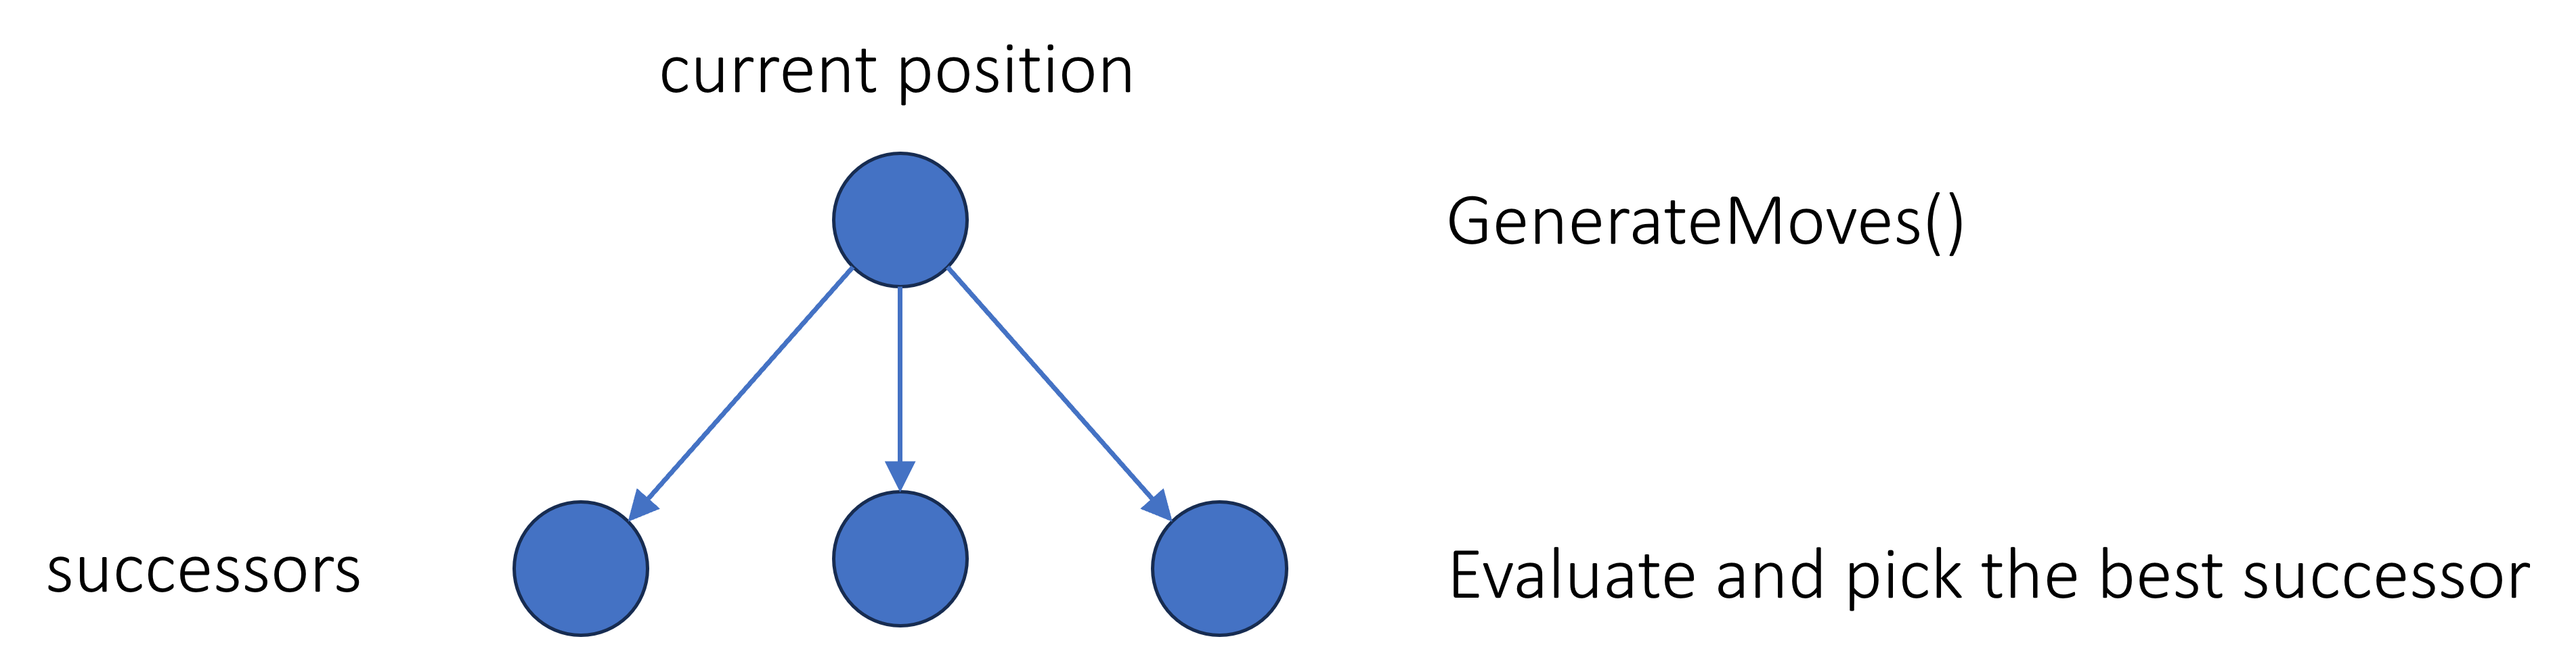

In [67]:
# alpha-beta player
# the player class basically just implements getting the next move in a position it is given
# it can also identify itself, useful later when we'll compete/compare different players

class abPlayer:
    def __init__(self, depth, hf):
        self.depth = depth   # search depth to which this player will search
        self.hf = hf         # heuristic function this player will use
        self.ID = 'AlphaBeta player using depth %d and heuristic %s.' % (depth, hf.__name__)
        
    def getMove(self, state, verbose=False):
        # returns the best-evaluated move and its evaluation
        # if there are several best moves, return a random one amongst them
        bestMoves, bestEval = [], -inf
        moves = state.GenerateMoves()
        for move in moves:
            state.Move(move)
            e = alphabeta(state, self.depth, -inf, inf, state.ptm == 1, self.hf)
            state.UndoMove(move)
            e *= state.ptm  # negamax principle
            if verbose: print(move, e)
            if e > bestEval:
                bestMoves, bestEval = [move], e
            elif e == bestEval:
                bestMoves.append(move)
        return bestMoves[randint(0,len(bestMoves)-1)], bestEval

In [70]:
# Monte-Carlo player
# while alphabeta player is defined by depth of search and heuristic used
# MC player is defined by the number of simulations it runs for each candidate move

class mcPlayer:
    def __init__(self, ngames):
        self.ngames = ngames   # number of simulations per candidate move
        self.ID = 'Monte-Carlo player using %d simulations per candidate move.' % ngames
        
    def getMove(self, state, verbose=False):
        # returns a best-evaluated move and its evaluation
        bestMove, bestEval = None, -inf
        moves = state.GenerateMoves()
        for move in moves:
            state.Move(move)
            e = mc(state, self.ngames)
            if verbose: print(move, e)
            state.UndoMove(move)
            e *= state.ptm  # negamax principle
            if e > bestEval:
                bestMove, bestEval = move, e
        return bestMove, bestEval

In [97]:
# this function plays one game for the given players
# useful for comparing player below
# it returns a score who won: +1 for crosses (player1), -1 for noughts (player2), 0 for draw

def playOneGame(p1, p2, randomFirstMove=False, verbose=False):
    # p1 and p2 are "player"-type objects
    if verbose:
        print('X:', p1.ID)
        print('O:', p2.ID)
    ttt = TicTacToe()
    if randomFirstMove: 
        ttt.Move(randint(0,8))   # make a random first move if we want more variability
        ptm = -1
        if verbose: print('Random first move played.')
    else:
        ptm = 1
    while not ttt.isTerminal():
        if ptm == 1: move, e = p1.getMove(ttt, verbose)
        else: move, e = p2.getMove(ttt, verbose)
        ptm *= -1
        if verbose: print('Eval:', e)
        ttt.Move(move)
        if verbose: ttt.PrintPosition()
    return ttt.won

Now we're finally ready to play some real games! Let's start comparing our players and how well they can play.

First, let's see what move different players would play for the winning position from before. Note there will be some randomness as if the player evaluates more than one move as best, it will play a random one amongst them. We will only search until depth 5 as we've seen before that both heuristics "see everything" at that depth and will play the truly best move.

In [85]:
ttt.PrintPosition()

   |   |   
---+---+---
   | X | O 
---+---+---
   |   |   


In [88]:
for depth in range(6):
    player = abPlayer(depth, basicHF)
    print('Player:', player.ID)
    print('Move and its evalutation:', player.getMove(ttt))
    player = abPlayer(depth, positionalHF)
    print('Player:', player.ID)
    print('Move and its evalutation:', player.getMove(ttt))
    print()

Player: AlphaBeta player using depth 0 and heuristic basicHF.
Move and its evalutation: (2, 0)
Player: AlphaBeta player using depth 0 and heuristic positionalHF.
Move and its evalutation: (2, 5)

Player: AlphaBeta player using depth 1 and heuristic basicHF.
Move and its evalutation: (3, 0)
Player: AlphaBeta player using depth 1 and heuristic positionalHF.
Move and its evalutation: (8, 2)

Player: AlphaBeta player using depth 2 and heuristic basicHF.
Move and its evalutation: (3, 0)
Player: AlphaBeta player using depth 2 and heuristic positionalHF.
Move and its evalutation: (2, 5)

Player: AlphaBeta player using depth 3 and heuristic basicHF.
Move and its evalutation: (8, 0)
Player: AlphaBeta player using depth 3 and heuristic positionalHF.
Move and its evalutation: (7, 2)

Player: AlphaBeta player using depth 4 and heuristic basicHF.
Move and its evalutation: (6, 1000000)
Player: AlphaBeta player using depth 4 and heuristic positionalHF.
Move and its evalutation: (0, 1000000)

Player: 

The game is very simple, so this comparison can have some problems. The only move that does *not* win is move "3", i.e. middle-left. But if you run the code above several times, you might observe the simple heuristic actually select move "3" as on shallower depths all moves seem equally good to it. The stronger heuristic rarely (likely never?) makes this mistake.

#### Monte-Carlo players and their move evaluations

So, how about the Monte-Carlo players? Let's see how they evaluate the above winning position and what they would play. We'll use from 10 (too few) to 10,000 (too much really) simulations per candidate move. We'll check the evaluation of all seven possible moves with different number of simulations. Note that at smaller number of simulations the results will be pretty... well, random ;)

In [93]:
for ngames in [10, 100, 1000, 10000]:
    print('Number of simulations:', ngames)
    for move in ttt.GenerateMoves():
        ttt.Move(move)
        print('  Move and eval:', move, mc(ttt, ngames))
        ttt.UndoMove(move)
    print()

Number of simulations: 10
  Move and eval: 0 2
  Move and eval: 1 2
  Move and eval: 2 8
  Move and eval: 3 5
  Move and eval: 6 7
  Move and eval: 7 8
  Move and eval: 8 8

Number of simulations: 100
  Move and eval: 0 72
  Move and eval: 1 63
  Move and eval: 2 70
  Move and eval: 3 17
  Move and eval: 6 69
  Move and eval: 7 72
  Move and eval: 8 66

Number of simulations: 1000
  Move and eval: 0 580
  Move and eval: 1 540
  Move and eval: 2 713
  Move and eval: 3 256
  Move and eval: 6 566
  Move and eval: 7 562
  Move and eval: 8 716

Number of simulations: 10000
  Move and eval: 0 5763
  Move and eval: 1 5767
  Move and eval: 2 7103
  Move and eval: 3 2943
  Move and eval: 6 5691
  Move and eval: 7 5662
  Move and eval: 8 7224



Not bad. Already with 100 simulations per candidate move, the only non-winning move is evaluated significantly worse that all the other moves. That means this move would not be played by the Monte-Carlo player with a reasonable number of simulations performed.

In [125]:
ttt = TicTacToe()
ttt.Move(1)
ttt.PrintPosition()

   | X |   
---+---+---
   |   |   
---+---+---
   |   |   


Okay, one more test for Monte-Carlo player. How would it evaluate the possible moves for the second player and which move would it play?

In [126]:
bestEval, bestMove = -inf, None
for m in range(9):
    if m == 1: continue
    ttt.Move(m)
    ev = mc(ttt, 10000)
    ttt.UndoMove(m)
    print("Move: %d, Eval: %d" % (m, ev))
    if ev * ttt.ptm > bestEval: bestEval, bestMove = ev * ttt.ptm, m
ttt.Move(bestMove)
print()
ttt.PrintPosition()

Move: 0, Eval: 1713
Move: 2, Eval: 1689
Move: 3, Eval: 3215
Move: 4, Eval: -413
Move: 5, Eval: 3116
Move: 6, Eval: 1404
Move: 7, Eval: 3689
Move: 8, Eval: 1562

   | X |   
---+---+---
   | O |   
---+---+---
   |   |   


Test passed. Remember that it's the second player's move and this is the *minimising* player. So the move with the lowest score is the preferred one.

#### Play a single game

Now we have all the code to compete different players against each other.

In [98]:
p1 = abPlayer(2, positionalHF)
p2 = mcPlayer(100)
#print('Player1:', p1.ID)
#print('Player2:', p2.ID)
result = playOneGame(p1, p2, True, True)   # random first move, verbose mode ON (display info)
print(['Noughts won!', 'Draw.', 'Crosses won!'][result+1])

X: AlphaBeta player using depth 2 and heuristic positionalHF.
O: Monte-Carlo player using 100 simulations per candidate move.
Random first move played.
0 25
1 64
2 36
3 35
4 4
5 56
6 17
7 44
Eval: -4
   |   |   
---+---+---
   | O |   
---+---+---
   |   | X 
0 2
1 1
2 3
3 1
5 1
6 3
7 1
Eval: 3
   |   | X 
---+---+---
   | O |   
---+---+---
   |   | X 
0 49
1 32
3 20
5 -13
6 61
7 34
Eval: 13
   |   | X 
---+---+---
   | O | O 
---+---+---
   |   | X 
0 -1000000
1 -1000000
3 2
6 -1000000
7 -1000000
Eval: 2
   |   | X 
---+---+---
 X | O | O 
---+---+---
   |   | X 
0 27
1 0
6 36
7 -7
Eval: 7
   |   | X 
---+---+---
 X | O | O 
---+---+---
   | O | X 
0 -1000000
1 0
6 -1000000
Eval: 0
   | X | X 
---+---+---
 X | O | O 
---+---+---
   | O | X 
0 0
6 100
Eval: 0
 O | X | X 
---+---+---
 X | O | O 
---+---+---
   | O | X 
6 0
Eval: 0
 O | X | X 
---+---+---
 X | O | O 
---+---+---
 X | O | X 
Draw.


The game trace (printout) might not be super pretty, but it gives interesting information about the play and how each player was "thinking". For noughts (second player, MIN) note that the evaluations are negated as the *minimum* is best for it.

These two players are quite strong, so draws are most likely. The game is really simple, after all.

## Play a tournament and compare different players

Finally, it's time to compare different players for real, not just by playing one game. In this section you can create various players and play a series of games between them. Don't forget to also switch sides (who goes first).

In [115]:
# play a series of games

def head2head(p1, p2, ngames=10, randomFirstMove=True, switchSide=True):
    print('X:', p1.ID)
    print('O:', p2.ID)
    if randomFirstMove: print('Random first move.')
    score = {-1:0, 0:0, +1:0}
    for game in range(ngames):
        score[playOneGame(p1, p2, randomFirstMove, False)] += 1
    print("Games played:", ngames)
    print("X won %d and O won %d games, with %d draws." % (score[+1], score[-1], score[0]))
    print()

    if switchSide:
        head2head(p2, p1, ngames, randomFirstMove, False)

In [109]:
# let's define some players and run them against one another
mc10 = mcPlayer(10)
mc100 = mcPlayer(100)
mc1000 = mcPlayer(1000)
ab2basic = abPlayer(2, basicHF)
ab2smart = abPlayer(2, positionalHF)
ab4smart = abPlayer(4, positionalHF)

In [118]:
# ... aaaaaand PLAY!
head2head(mc10, mc100, 100)

X: Monte-Carlo player using 10 simulations per candidate move.
O: Monte-Carlo player using 100 simulations per candidate move.
Random first move.
Games played: 100
X won 27 and O won 20 games, with 53 draws.

X: Monte-Carlo player using 100 simulations per candidate move.
O: Monte-Carlo player using 10 simulations per candidate move.
Random first move.
Games played: 100
X won 69 and O won 1 games, with 30 draws.



In [119]:
# note: this takes a bit longer if you run 100 games per tournament
head2head(mc10, mc1000, 100)

X: Monte-Carlo player using 10 simulations per candidate move.
O: Monte-Carlo player using 1000 simulations per candidate move.
Random first move.
Games played: 100
X won 24 and O won 21 games, with 55 draws.

X: Monte-Carlo player using 1000 simulations per candidate move.
O: Monte-Carlo player using 10 simulations per candidate move.
Random first move.
Games played: 100
X won 73 and O won 0 games, with 27 draws.



No surprises here, more simulations result in better play. Not much difference between 100 and 1000 simulations in beating the poor 10 simulations bot. The only surprise is perhaps, that the poor mc10 player actually wins some games! Well, that's randomness at work.

Oh, and mc1000 is quite slow. See, this is motivation for MCTS, to better use the time available, and not spend too much time on obviously bad moves.

In [120]:
head2head(ab2basic, ab2smart, 100)

X: AlphaBeta player using depth 2 and heuristic basicHF.
O: AlphaBeta player using depth 2 and heuristic positionalHF.
Random first move.
Games played: 100
X won 9 and O won 7 games, with 84 draws.

X: AlphaBeta player using depth 2 and heuristic positionalHF.
O: AlphaBeta player using depth 2 and heuristic basicHF.
Random first move.
Games played: 100
X won 60 and O won 4 games, with 36 draws.



Alright! Remember, I said above that the "smarter" heuristic function should guide the play better and consequently win more games. Before it was a speculation, but the above result shows it is true!

In [122]:
head2head(ab2smart, ab4smart, 1000)

X: AlphaBeta player using depth 2 and heuristic positionalHF.
O: AlphaBeta player using depth 4 and heuristic positionalHF.
Random first move.
Games played: 1000
X won 0 and O won 8 games, with 992 draws.

X: AlphaBeta player using depth 4 and heuristic positionalHF.
O: AlphaBeta player using depth 2 and heuristic positionalHF.
Random first move.
Games played: 1000
X won 0 and O won 0 games, with 1000 draws.



Right. The game is just too simple to compare these two bots. But depth 4 smart bot doesn't lose at all it seems. But trust me, searching deeper *does* result in better play! ;)

Anyway, I really enjoyed programming this. Hope you have some fun as well comparing other bots. You can also program a (bit) harder game for the bots to play.